In [14]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
from scipy.stats import linregress
import json
import pprint
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

# Import API key
from api_keys import api_key

In [15]:
# read in csv
oscar_data= pd.read_csv("Resources/oscar_data.csv")

In [16]:
base_url = "https://api.themoviedb.org/3/"
responseid = {'Title' : [],'ID' : [], 'Vote Average' : [], 'Release Date' : []}

years = ["1998", "2003", "2008", "2013", "2018"]

# "for loop" to loop through multiple years
for year in years:
    startdate = f"{year}-01-01"
    enddate = f"{year}-12-31"

    all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}').json()
    total_pages = json.dumps(all_movies_response["total_pages"], indent=4, sort_keys=True)

    # Request from API for each month
    for i in range(1,int(total_pages)//30):

        # Request API for different pages
        all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}&page={i}').json()
        
        # Compiles results into a dictionary
        for j in range(len(all_movies_response["results"])):
            responseid['Title'].append(all_movies_response["results"][j]["title"])
            responseid['ID'].append(all_movies_response["results"][j]["id"])
            responseid['Vote Average'].append(all_movies_response["results"][j]["vote_average"])
            responseid['Release Date'].append(all_movies_response["results"][j]["release_date"])

In [17]:
# Converts dictionary into dataframe
moviedata = pd.DataFrame(responseid)

# Input string
moviedata['Release Date'] = pd.to_datetime(moviedata['Release Date'], utc=True)

# As Release Dates are text, they are first converted to UNIX 
moviedata['Release Date UNIX'] = moviedata['Release Date'].astype(np.int64)
moviedata = moviedata.sort_values("Release Date")

# Release Date is split into Day, Month and Year Columns
moviedata['Day'] = moviedata['Release Date'].dt.day
moviedata['Month'] = moviedata['Release Date'].dt.strftime('%b')
moviedata['Month Number'] = moviedata['Release Date'].dt.month
moviedata['Year'] = moviedata['Release Date'].dt.year
moviedata = moviedata.reset_index(drop=True)

moviedata

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year
0,Fallen,9411,6.788,1998-01-16 00:00:00+00:00,884908800000000000,16,Jan,1,1998
1,Buffalo '66,9464,7.110,1998-01-20 00:00:00+00:00,885254400000000000,20,Jan,1,1998
2,Gia,14533,7.123,1998-01-31 00:00:00+00:00,886204800000000000,31,Jan,1,1998
3,The Horse Whisperer,547,6.898,1998-02-01 00:00:00+00:00,886291200000000000,1,Feb,2,1998
4,Sphere,10153,6.100,1998-02-13 00:00:00+00:00,887328000000000000,13,Feb,2,1998
...,...,...,...,...,...,...,...,...,...
1215,On the Basis of Sex,339380,7.406,2018-12-25 00:00:00+00:00,1545696000000000000,25,Dec,12,2018
1216,Destroyer,471507,5.900,2018-12-25 00:00:00+00:00,1545696000000000000,25,Dec,12,2018
1217,Stan & Ollie,394741,6.974,2018-12-28 00:00:00+00:00,1545955200000000000,28,Dec,12,2018
1218,Black Mirror: Bandersnatch,569547,6.766,2018-12-28 00:00:00+00:00,1545955200000000000,28,Dec,12,2018


In [18]:
# Nominated movies are added to a list by using the lambda function, and added to the moviedata dataframe as new columns
titles = moviedata['Title'].to_list()

for year in years:
    noms = []
    for movie in titles:
        mask = oscar_data[oscar_data.apply(lambda row: row.astype(str).str.contains(re.escape(str(movie)), case=False).any(), axis=1)]
        
        if mask.empty:
            noms.append("No")
            
        else:
            if mask['Year'].values[0] == year:
                noms.append("Yes")
            else:
                noms.append("No")
                
    moviedata[f'Nominated {year}'] = noms
    
moviedata.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated 1998,Nominated 2003,Nominated 2008,Nominated 2013,Nominated 2018
0,Fallen,9411,6.788,1998-01-16 00:00:00+00:00,884908800000000000,16,Jan,1,1998,No,No,No,No,No
1,Buffalo '66,9464,7.110,1998-01-20 00:00:00+00:00,885254400000000000,20,Jan,1,1998,No,No,No,No,No
2,Gia,14533,7.123,1998-01-31 00:00:00+00:00,886204800000000000,31,Jan,1,1998,No,No,No,No,No
3,The Horse Whisperer,547,6.898,1998-02-01 00:00:00+00:00,886291200000000000,1,Feb,2,1998,Yes,No,No,No,No
4,Sphere,10153,6.100,1998-02-13 00:00:00+00:00,887328000000000000,13,Feb,2,1998,No,No,No,No,No


In [23]:
# moviedata dataframe is reduced to only nominated movies
nominated_movies = moviedata.loc[(moviedata[f"Nominated {years[0]}"] == "Yes") |
              (moviedata[f"Nominated {years[1]}"] == "Yes") |
              (moviedata[f"Nominated {years[2]}"] == "Yes") |
              (moviedata[f"Nominated {years[3]}"] == "Yes") |
              (moviedata[f"Nominated {years[4]}"] == "Yes"),:]

nominated_movies = nominated_movies.drop(columns=[f"Nominated {years[0]}", f"Nominated {years[1]}", f"Nominated {years[2]}"])

nominated_movies.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated 2013,Nominated 2018
3,The Horse Whisperer,547,6.898,1998-02-01 00:00:00+00:00,886291200000000000,1,Feb,2,1998,No,No
16,Quest for Camelot,18937,6.844,1998-05-15 00:00:00+00:00,895190400000000000,15,May,5,1998,No,No
19,The Truman Show,37165,8.139,1998-06-04 00:00:00+00:00,896918400000000000,4,Jun,6,1998,No,No
22,Mulan,10674,7.915,1998-06-18 00:00:00+00:00,898128000000000000,18,Jun,6,1998,No,No
24,Out of Sight,1389,6.676,1998-06-26 00:00:00+00:00,898819200000000000,26,Jun,6,1998,No,No


In [24]:
# New column is added, value is based on whether the movie was released during, or outside of Oscar Season.
season = []

for row in nominated_movies['Month']:
    if row in ("Nov", "Dec"):
        season.append("Yes")
    else:
        season.append("No")

nominated_movies['Oscar Season'] = season

nominated_movies

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated 2013,Nominated 2018,Oscar Season
3,The Horse Whisperer,547,6.898,1998-02-01 00:00:00+00:00,886291200000000000,1,Feb,2,1998,No,No,No
16,Quest for Camelot,18937,6.844,1998-05-15 00:00:00+00:00,895190400000000000,15,May,5,1998,No,No,No
19,The Truman Show,37165,8.139,1998-06-04 00:00:00+00:00,896918400000000000,4,Jun,6,1998,No,No,No
22,Mulan,10674,7.915,1998-06-18 00:00:00+00:00,898128000000000000,18,Jun,6,1998,No,No,No
24,Out of Sight,1389,6.676,1998-06-26 00:00:00+00:00,898819200000000000,26,Jun,6,1998,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
1182,The Favourite,375262,7.521,2018-11-23 00:00:00+00:00,1542931200000000000,23,Nov,11,2018,No,Yes,Yes
1193,Spider-Man: Into the Spider-Verse,324857,8.405,2018-12-06 00:00:00+00:00,1544054400000000000,6,Dec,12,2018,No,Yes,Yes
1196,Mary Queen of Scots,457136,6.576,2018-12-07 00:00:00+00:00,1544140800000000000,7,Dec,12,2018,No,Yes,Yes
1203,Mary Poppins Returns,400650,6.507,2018-12-13 00:00:00+00:00,1544659200000000000,13,Dec,12,2018,No,Yes,Yes


In [25]:
# Dataset is grouped to discern number of movies released in/out of Oscar Season
nominated_movies_grouped = nominated_movies.groupby(["Year", "Oscar Season"]).count()
nominated_movies_grouped = nominated_movies_grouped.reset_index()
nominated_movies_grouped

,Year,Oscar Season,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Nominated 2013,Nominated 2018
0,1998,No,11,11,11,11,11,11,11,11,11,11
1,1998,Yes,7,7,7,7,7,7,7,7,7,7
2,2003,No,9,9,9,9,9,9,9,9,9,9
3,2003,Yes,9,9,9,9,9,9,9,9,9,9
4,2008,No,16,16,16,16,16,16,16,16,16,16
5,2008,Yes,6,6,6,6,6,6,6,6,6,6
6,2013,No,15,15,15,15,15,15,15,15,15,15
7,2013,Yes,12,12,12,12,12,12,12,12,12,12
8,2018,No,20,20,20,20,20,20,20,20,20,20
9,2018,Yes,10,10,10,10,10,10,10,10,10,10


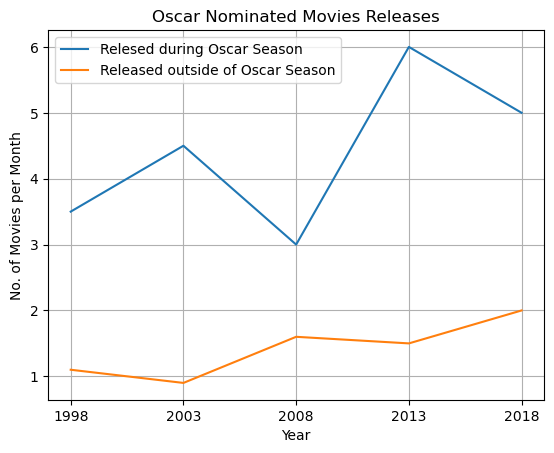

In [30]:
# Line plot of average Oscar nomianted movies per month vs year
x_values = nominated_movies_grouped["Year"].unique().tolist()
y_values_oscar_season = nominated_movies_grouped.loc[nominated_movies_grouped["Oscar Season"] == "Yes","Title"].tolist()
y_values_non_oscar_season = nominated_movies_grouped.loc[nominated_movies_grouped["Oscar Season"] == "No","Title"].tolist()

tick_locations = [x for x in x_values]

plt.plot(x_values, [value/2 for value in y_values_oscar_season], label="Relesed during Oscar Season")
plt.plot(x_values, [value/10 for value in y_values_non_oscar_season], label="Released outside of Oscar Season")

plt.xticks(tick_locations, x_values)
plt.xlabel("Year")
plt.ylabel("No. of Movies per Month")

plt.title("Oscar Nominated Movies Releases")
plt.grid(True)
plt.legend(loc="best")

plt.savefig('resources/output/oscar_line_plot_multiyear.png')
plt.show()